__crux__: The residual errors from forecasts on a time series provide another source of information that we can model.

Just like the input observations themselves, the residual errors from a time series can have temporal structure like trends, bias, and seasonality. Any temporal structure in the time series of residual forecast errors is useful as a diagnostic as it suggests information that could be incorporated into the predictive model. An ideal model would leave no structure in the residual error, just random fluctuations that cannot be modeled.Structure in the residual error can also be modeled directly. There may be complex signals in the residual error that are difficult to directly incorporate into the model. Instead, we can create a model of the residual error time series and predict the expected error for your model. The predicted error can then be subtracted from the model prediction and in turn provide an additional lift in performance.

Residual errors themselves form a time series that can have temporal structure. A simple autoregression model of this structure can be used to predict the forecast error, which in turn can be used to correct forecasts. This type of model is called a __moving average model__, the same name but very different from __moving average smoothing__.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

In [2]:
birth = pd.read_csv(r"./Datasets/daily-total-female-births.csv"
                    ,index_col=0,parse_dates=True)

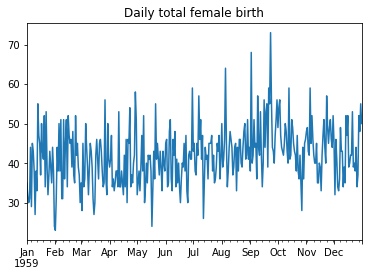

In [3]:
_ = birth.Births.plot().set(xlabel="",title="Daily total female birth")

In [4]:
# Assuming Persistance Model # i.e forecast at 't+1' is 't'
ts = pd.DataFrame()
ts['t']   = birth['Births'].shift(1)
ts['t+1'] = birth['Births']

In [5]:
train = ts.iloc[:int(len(ts)*.66)]
test = ts[~ts.index.isin(train.index)]

Sample lenght of train, test and complete sample 240 125 365
RMSE : 9.151


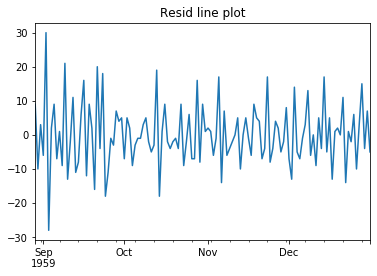

In [6]:
print("Sample lenght of train, test and complete sample",len(train),len(test),len(ts))

rmse = np.sqrt(mean_squared_error(test['t'],test['t+1']))
print("RMSE : {:.3f}".format(rmse))

resid = test['t+1'] - test['t']
resid = resid.dropna()
_ = resid.plot().set(title='Resid line plot',xlabel='')

In [7]:
print(resid.head().to_string())

Date
1959-08-29     9.0
1959-08-30   -10.0
1959-08-31     3.0
1959-09-01    -6.0
1959-09-02    30.0


In [8]:
## Auto-regression of Residual Error
from statsmodels.tsa.ar_model import AR

In [9]:
resid_train = (train['t+1']-train['t']).dropna()
fit = AR(resid_train,dates=resid_train.index).fit()

C:\Users\91882\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)
C:\

In [10]:
print("Lags :",fit.k_ar)
print("Params :\n",fit.params.to_string())
# The autoregression model requires 
# the residual error of the 15 previous time steps.

Lags : 15
Params :
 const    0.101207
L1.y    -0.849406
L2.y    -0.777836
L3.y    -0.733450
L4.y    -0.689021
L5.y    -0.592706
L6.y    -0.537673
L7.y    -0.425534
L8.y    -0.248612
L9.y    -0.199721
L10.y   -0.159540
L11.y   -0.110455
L12.y   -0.140456
L13.y   -0.133000
L14.y   -0.125158
L15.y   -0.036158


In [11]:
coeffs = fit.params.values

In [12]:
resid = (ts['t+1'] - ts['t']).dropna()
resid = resid.iloc[len(train)-len(coeffs):] 
# each AR prediction of resid will require trailing 
# AR cofficents terms, we have included these terms

In [13]:
resid_ar_predictions= [] # predictions based on AR process for resid terms
# now resid is the the series which can test (resid) + some extra lag terms in starting
# we start for len(coffs)+  location and go upto len of resid
for ind in range(len(coeffs),len(resid)+1):
    resid_ar_predictions.append(coeffs[0]+ np.dot(np.flip(coeffs[1:]),resid.iloc[ind-len(coeffs):ind-1].values))

In [14]:
resid_ar_predictions = pd.Series(resid_ar_predictions,index=test.index)

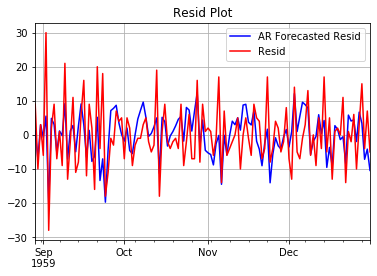

In [15]:
resid_ar_predictions.plot(color='b')
(test['t+1']-test['t']).plot(color='r')
plt.legend(['AR Forecasted Resid','Resid'])
_ = plt.title("Resid Plot")
plt.grid(True)
_ = plt.xlabel("")

In [16]:
## Correct Predictions with a Model of Residuals
# Yhat = Yhat + Pred Error
corrected_forecast = test['t'] + resid_ar_predictions

In [17]:
rmse =  np.sqrt(mean_squared_error(test['t+1'],corrected_forecast))
print("RMSE : {:.2f}".format(rmse))
# This is improvement from earlier rmse of 9.5

RMSE : 7.50


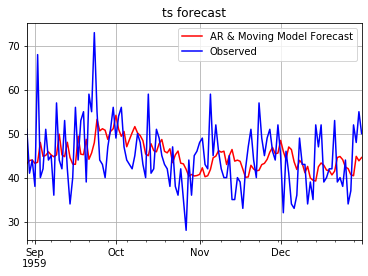

In [18]:
corrected_forecast.plot(color='r')
test['t+1'].plot(color='b')
plt.xlabel("")
plt.title("ts forecast")
plt.grid(True)
_ = plt.legend(['AR & Moving Model Forecast','Observed'])

## Summary

- About the Moving Average (MA) approach to developing an autoregressive model to residual error.
- How to develop and evaluate a model of residual error to predict forecast error.
- How to use the predictions of forecast error to correct predictions and improve model skill.